# Modelling patch-clamp experiments: simplified models

In the previous notebooks we presented a model of patch-clamp experiments.
Here, we explore how it can be simplified for parameter estimation purposes.

We start from the main schematic and equations (but omitting leak and voltage offset for simplicity).

<img src="resources/patch-comp-6-full.png" style="margin:auto" />

_**Figure 1**: The full patch-clamp schematic_

We derived two models: **(1, 2a, 3a, 4, 5, 6a)** and **(1, 2b, 3b, 4, 5, 6b)**.

\begin{align}
2.1. && C_m\dot{V}_m = \frac{V_p - V_m}{R_s} - I
\end{align}

\begin{align}
2.2a. && (C_p+C_f)\dot{V}_p &= \frac{V_o - V_p}{R_f} - \frac{V_p - V_m}{R_s} + C_f\dot{V}_o + C_m^* \dot{V}_\text{est} + C_p^* \dot{V}_\text{ref} \\
2.2b. && C_f\dot{V}_o &= \frac{V_p-V_o}{R_f} + \frac{V_p-V_m}{R_s} + \left(C_p+C_f\right)\dot{V}_p - C_m^* \dot{V}_\text{est} - C_p^* \dot{V}_\text{ref}
\end{align}

\begin{align}
2.3a. && \tau_a \dot{V}_o &= V_\text{ref} - V_p \\
2.3b. && \tau_c\dot{V}_p &= V_\text{ref} - V_p
\end{align}

\begin{align}
2.4. && \dot{V}_\text{est} &= \frac{V_c - V_\text{est}}{(1 - \beta)R_s^*C_m^*}   
\end{align}

\begin{align}
2.5. && \tau_\text{sum}\dot{V}_\text{ref} = V_c + \alpha R_s^* I_\text{obs} + \beta R_s^* C_m^* \dot{V}_\text{est} - V_\text{ref}
\end{align}

\begin{align}
2.6a. && R_f I_\text{obs} &= V_o - V_\text{ref} \\
2.6b. && R_f I_\text{obs} &= V_o - V_p
\end{align}

where 2.2a and 2.2b are different ways to express the same relation, so that the models only differ in equations 2.3 and 2.6.

## Op-amp speed

To derive a simplified "Sigworth-style" model, we omit op-amp equation 2.3a, and switch from 2.2a to 2.2b as an equation for $V_o$.
Next, we set $V_p = V_\text{ref}$ and $\dot{V}_p = \dot{V}_\text{ref}$ to find

\begin{align}
3.1. && C_m\dot{V}_m = \frac{V_\text{ref} - V_m}{R_s} - I
\end{align}

\begin{align}
3.2. && C_f\dot{V}_o &= \frac{V_\text{ref} - V_m}{R_s} - \frac{V_o - V_\text{ref}}{R_f} + \left(C_f+C_p- C_p^*\right)\dot{V}_\text{ref} - C_m^* \dot{V}_\text{est}
\end{align}

\begin{align}
3.3. && \dot{V}_\text{est} &= \frac{V_c - V_\text{est}}{(1 - \beta)R_s^*C_m^*}   
\end{align}

\begin{align}
3.4. && \tau_\text{sum}\dot{V}_\text{ref} = V_c + \alpha R_s^* I_\text{obs} + \beta R_s^* C_m^* \dot{V}_\text{est} - V_\text{ref}
\end{align}

\begin{align}
3.5. && R_f I_\text{obs} &= V_o - V_\text{ref}
\end{align}

Equivalently, we can start from the "Lei-style" model, omit 2.3b, and equate $V_p$ with $V_\text{ref}$ to find the same model. 

The new form of equation 2 makes it interpretable:

\begin{align}
C_f\dot{V}_o &= \frac{V_\text{ref} - V_m}{R_s} - \frac{V_o - V_\text{ref}}{R_f} + \left(C_f+C_p- C_p^*\right)\dot{V}_\text{ref} - C_m^* \dot{V}_\text{est}
\end{align}

1. In steady-state, the first two terms must cancel each other out, so stability is reached when the voltage drop over $R_s$ equals the voltage drop over $R_f$.
2. If $V_\text{ref}$ goes up (or $V_m$ goes down), the derivative will become positive so that $V_o$ will grow until a new equilibrium is reached.
3. The final two terms cause transient capacitative spikes any time $V_\text{ref}$ or $V_\text{est}$ change, and the effects of $C_p$ are cancelled out by $C_p^*$.

In [1]:
import myokit

import numpy as np
import matplotlib.pyplot as plt

In [2]:
mAs = myokit.parse_model('''
[[model]]
desc: Simplified model
amp.Vm = -80
amp.Vo = -80
amp.Ve = -80
amp.Vr = -80

[engine]
time = 0 [ms] in [ms] bind time
pace = 0 bind pace

[amp]
alpha = 0.7
beta = 0.7
Rs = 15e-3 [GOhm] in [GOhm]
Rs_est = 14e-3 [GOhm] in [GOhm]
Cm = 25 [pF] in [pF]
Cm_est = 24 [pF] in [pF]
Cp = 5 [pF] in [pF]
Cp_est = 4.9 [pF] in [pF]
Rf = 0.5 [GOhm] in [GOhm]
Cf = 0.15 [pF] in [pF]
tau_sum = 10e-3 [ms] in [ms]
I = 10 [nS] * Vm
    in [pA]
Vc = engine.pace * 1 [mV]
    in [mV]
dot(Vm) = (Vr - Vm) / (Rs * Cm) - I / Cm
    in [mV]
dot(Vo) = ((Vr - Vm) / Rs - (Vo - Vr) / Rf +
            (Cf + Cp - Cp_est) * dot(Vr) - Cm_est * dot(Ve)
          ) / Cf
    in [mV]
dot(Ve) = (Vc - Ve) / ((1 - beta) * Rs_est * Cm_est)
    in [mV]
dot(Vr) = (Vc + alpha * Rs_est * I_obs + beta * Rs_est * Cm_est * dot(Ve) - Vr) / tau_sum
    in [mV]
I_obs = (Vo - Vr) / Rf
    in [pA]
''')
mAs.check_units(myokit.UNIT_STRICT)

In [3]:
mA = myokit.parse_model('''
[[model]]
desc: Compensated model (1, 2a, 3a, 4, 5, 6a)
amp.Vm = -80
amp.Vp = -80
amp.Vo = -80
amp.Ve = -80
amp.Vr = -80

[engine]
time = 0 [ms] in [ms] bind time
pace = 0 bind pace

[amp]
alpha = 0.7
beta = 0.7
Rs = 15e-3 [GOhm] in [GOhm]
Rs_est = 14e-3 [GOhm] in [GOhm]
Cm = 25 [pF] in [pF]
Cm_est = 24 [pF] in [pF]
Cp = 5 [pF] in [pF]
Cp_est = 4.9 [pF] in [pF]
Rf = 0.5 [GOhm] in [GOhm]
Cf = 0.15 [pF] in [pF]
tau_amp = 20e-6 [ms] in [ms]
tau_sum = 10e-3 [ms] in [ms]
I = 10 [nS] * Vm
    in [pA]
Vc = engine.pace * 1 [mV]
    in [mV]
dot(Vm) = (Vp - Vm) / (Rs * Cm) - I / Cm : Eq 1
    in [mV]
dot(Vp) = ((Vo - Vp) / Rf - (Vp - Vm) / Rs +
            Cf * dot(Vo) + Cm_est * dot(Ve) + Cp_est * dot(Vr)
          ) / (Cp + Cf) : Eq 2a
    in [mV]
dot(Vo) = (Vr - Vp) / tau_amp : Eq 3a
    in [mV]
dot(Ve) = (Vc - Ve) / ((1 - beta) * Rs_est * Cm_est) : Eq 4
    in [mV]
dot(Vr) = (Vc + alpha * Rs_est * I_obs + beta * Rs_est * Cm_est * dot(Ve) - Vr) / tau_sum : Eq 5
    in [mV]
I_obs = (Vo - Vr) / Rf : Eq 6a
    in [pA]
''')
mA.check_units(myokit.UNIT_STRICT)

In [4]:
vlo, vhi = -80, 20
p = myokit.Protocol()
p.add_step(level=vlo, duration=5)
p.add_step(level=vhi, duration=15)

In [5]:
def axs(fig, sub=(1, 1, 1), xlabel='Time (ms)', ylabel=''):
    ax = fig.add_subplot(*sub)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    return ax

def ins(ax, loc=(0.05, 0.20, 0.40, 0.65)):
    ins = ax.inset_axes(loc)
    ins.set_yticklabels([])
    ins.set_xlim(t1, t2)
    ins.patch.set_alpha(0.5)    
    return ins

def plot(d, t1, t2, axes=None, label=None, ls=None):
    if axes is None:
        fig = plt.figure(figsize=(15, 12))
        
        ax1 = axs(fig, (3, 2, 1), 'Vm (mV)')
        ax2 = axs(fig, (3, 2, 2), 'Vp (mV)')
        ax3 = axs(fig, (3, 2, 3), 'Vest (mV)')
        ax4 = axs(fig, (3, 2, 4), 'Vo (mV)')
        ax5 = axs(fig, (3, 2, 5), 'Vref (mV)')
        ax6 = axs(fig, (3, 2, 6), 'Iobs (mV)')
        in1, in2 = ins(ax1), ins(ax2)
        in4, in5, in6 = ins(ax4), ins(ax5), ins(ax6)
        in1.set_xlim(5, 10)
        in1.set_ylim(10, 23)
        in5.set_ylim(-30, 60)
    else:
        [ax1, ax2, ax3, ax4, ax5, ax6, in1, in2, in4, in5, in6] = axes
        
    ax1.plot(d.time(), d['amp.Vm'], label=label, ls=ls)
    in1.plot(d.time(), d['amp.Vm'], label=label, ls=ls)
    if 'amp.Vp' in d:
        ax2.plot(d.time(), d['amp.Vp'], ls=ls)
        in2.plot(d.time(), d['amp.Vp'], ls=ls)
    ax3.plot(d.time(), d['amp.Ve'], ls=ls)
    if 'amp.Vo' in d:
        ax4.plot(d.time(), d['amp.Vo'], ls=ls)
        in4.plot(d.time(), d['amp.Vo'], ls=ls)
    ax5.plot(d.time(), d['amp.Vr'], ls=ls)
    in5.plot(d.time(), d['amp.Vr'], ls=ls)
    ax6.plot(d.time(), d['amp.I_obs'], ls=ls)
    in6.plot(d.time(), d['amp.I_obs'], ls=ls)
    
    return [ax1, ax2, ax3, ax4, ax5, ax6, in1, in2, in4, in5, in6]

In [6]:
tol = 1e-8

t0 = 10
t1 = 4.9
t2 = 6

sA = myokit.Simulation(mA, p)
sA.set_tolerance(tol, tol)

sAs = myokit.Simulation(mAs, p)
sAs.set_tolerance(tol, tol)

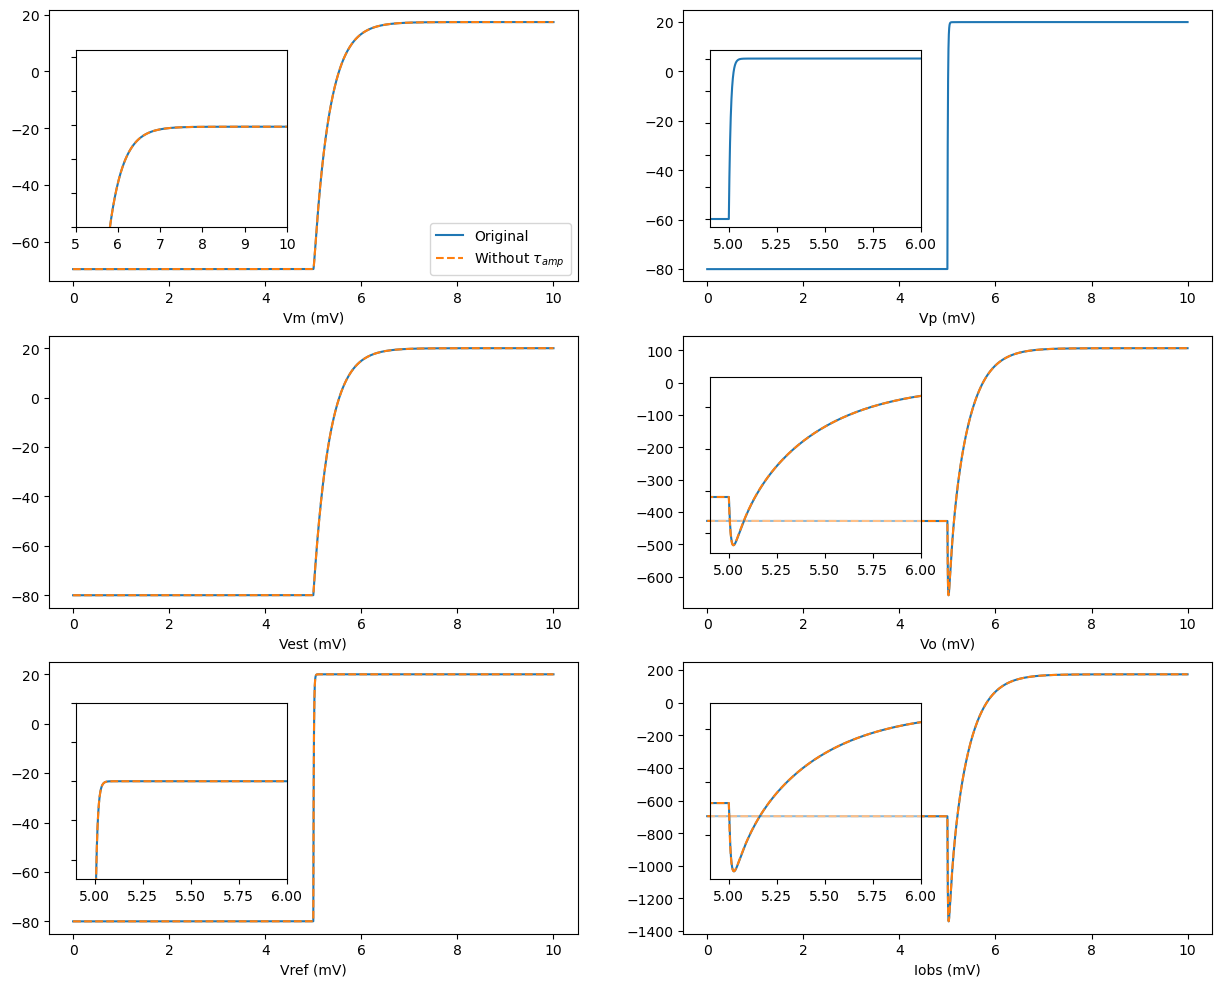

In [7]:
sA.set_constant('amp.alpha', 0)        # No correction
sA.set_constant('amp.beta', 0)         # No prediction

sAs.set_constant('amp.alpha', 0)        # No correction
sAs.set_constant('amp.beta', 0)         # No prediction

sA.pre(t1)
sAs.pre(t1)
dA = sA.run(t0)
dAs = sAs.run(t0)
ax = plot(dA, t1, t2, label='Original')
ax = plot(dAs, t1, t2, label=r'Without $\tau_{amp}$', ls='--', axes=ax)
ax[0].legend(loc='lower right')
plt.show()

And with compensation/prediction enabled:

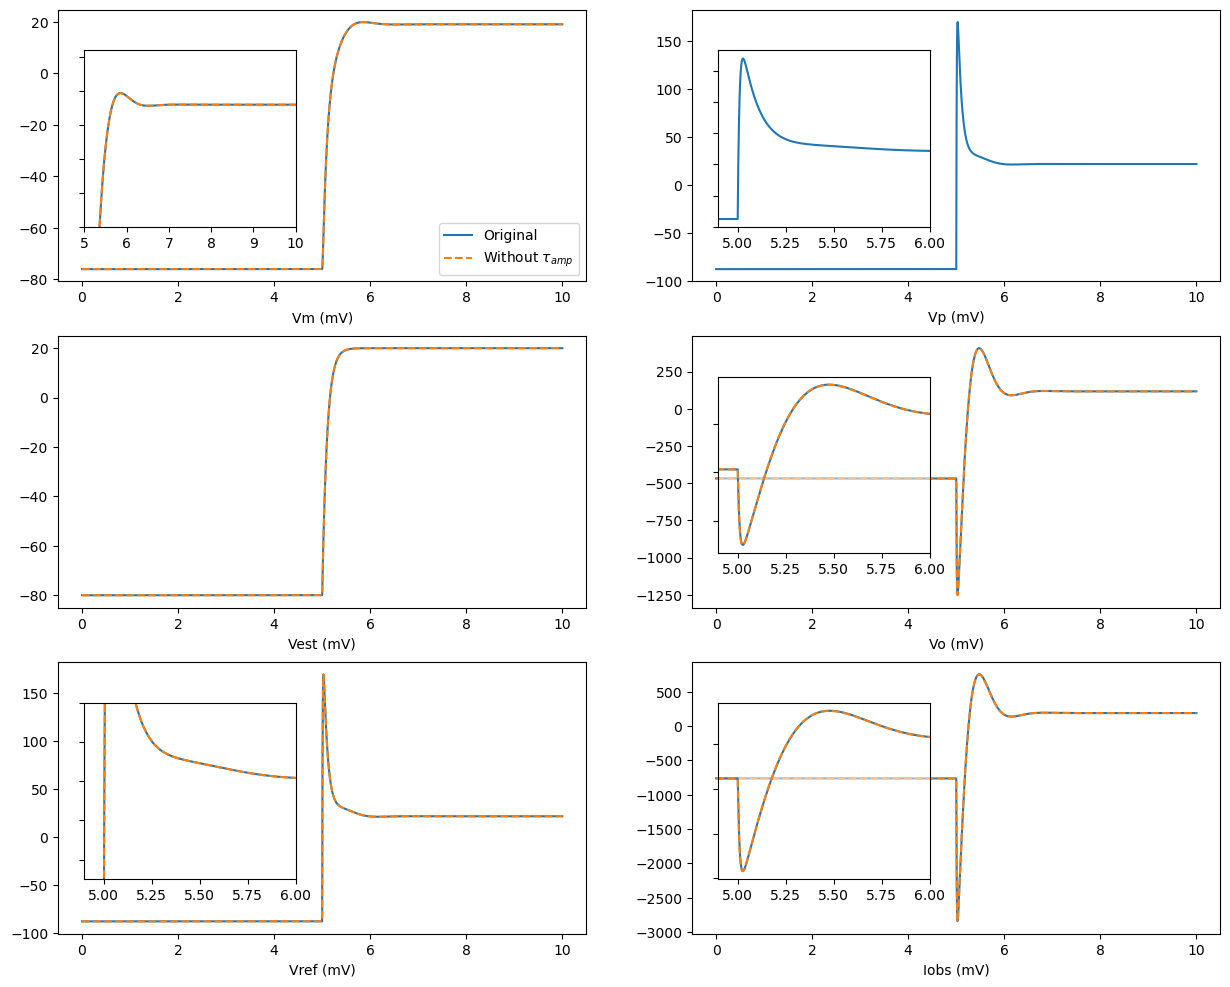

In [8]:
for s in (sA, sAs):
    s.reset()
    s.set_constant('amp.alpha', 0.7)
    s.set_constant('amp.beta', 0.7)
    s.set_tolerance(1e-10, 1e-10)
    s.pre(t1)

dt = 1e-3
dA = sA.run(t0)
dAs = sAs.run(t0)

tz = 0.05
ax = plot(dA, t1, t2, label='Original')
ax = plot(dAs, t1, t2, ax, label=r'Without $\tau_{amp}$', ls='--')
ax[0].legend(loc='lower right')
plt.show()

Both simulations look very similar indeed!

We can experiment a little to see at which values of $\tau_\text{amp}$ we might expect a difference (with all other parameter unchanged):

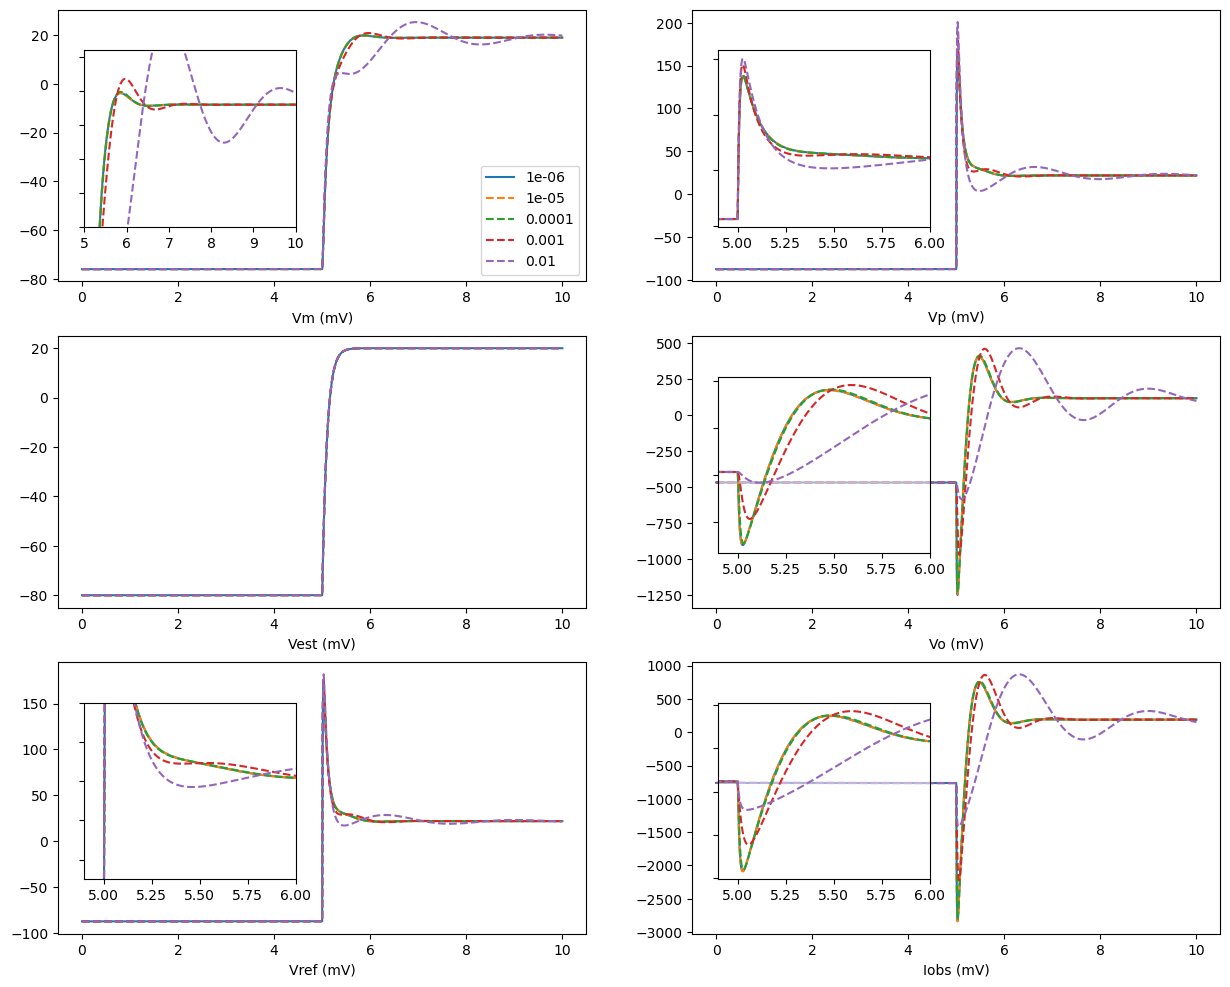

In [9]:
ax = plot(dA, t1, t2, label=str(1e-6))

for tau in (1e-5, 1e-4, 1e-3, 1e-2):
    sA.reset()
    sA.set_constant('amp.tau_amp', tau)
    sA.pre(t1)
    d = sA.run(t0)
    plot(d, t1, t2, ax, label=str(tau), ls='--')

ax[0].legend(loc='lower right')    
plt.show()

This shows that we need to go up several orders of magnitude before $\tau_\text{amp}$ has a significant impact on this experiment.

## Fast capacitance

In the above equations, the only appearance of the "fast" capacitance $C_p$ is in the term

\begin{align}
\left(C_f + C_p - C_p^*\right)\dot{V}_\text{ref}
\end{align}

If we assume that

1. $C_p$ is well matched by $C_p^*$
2. The duration of the remaining artefact is too short to affect most ionic currents

then it might make sense to omit the $C_p - C_p^*$ term entirely, and remove one parameter to be estimated from the system.

A second reason why this might be a good idea is how the contribution of $C_p$ and $C_p^*$ shows up in the observable output $I_\text{obs}$.
Here, it takes the form of two exponentials of a very large magnitude, but with opposite signs and highly similar time constants.
Remembering that the use of a single $C_p$ was an approximation to represent several capacitative effects, it seems very unlikely that our model could fit the fast-capacitance part of our observations well.

With this reasoning, we can propose a 4th model, specifically for use in parameter estimation of currents expected to have much slower dynamics than the fast capacitative transients.

\begin{align}
3.2b. && C_f\dot{V}_o &= \frac{V_\text{ref} - V_m}{R_s} - \frac{V_o - V_\text{ref}}{R_f} + C_f \dot{V}_\text{ref} - C_m^* \dot{V}_\text{est}
\end{align}

In [10]:
mBs = myokit.parse_model('''
[[model]]
desc: Simplified model without Cp and Cp_est
amp.Vm = -80
amp.Vo = -80
amp.Ve = -80
amp.Vr = -80

[engine]
time = 0 [ms] in [ms] bind time
pace = 0 bind pace

[amp]
alpha = 0.7
beta = 0.7
Rs = 15e-3 [GOhm] in [GOhm]
Rs_est = 14e-3 [GOhm] in [GOhm]
Cm = 25 [pF] in [pF]
Cm_est = 24 [pF] in [pF]
Rf = 0.5 [GOhm] in [GOhm]
Cf = 0.15 [pF] in [pF]
tau_sum = 10e-3 [ms] in [ms]
I = 10 [nS] * Vm
    in [pA]
Vc = engine.pace * 1 [mV]
    in [mV]
dot(Vm) = (Vr - Vm) / (Rs * Cm) - I / Cm
    in [mV]
dot(Vo) = ((Vr - Vm) / Rs - (Vo - Vr) / Rf + Cf * dot(Vr) - Cm_est * dot(Ve)) / Cf
    in [mV]
dot(Ve) = (Vc - Ve) / ((1 - beta) * Rs_est * Cm_est)
    in [mV]
dot(Vr) = (Vc + alpha * Rs_est * I_obs + beta * Rs_est * Cm_est * dot(Ve) - Vr) / tau_sum
    in [mV]
I_obs = (Vo - Vr) / Rf
    in [pA]
''')
mBs.check_units(myokit.UNIT_STRICT)

In [11]:
sAs = myokit.Simulation(mAs, p)
sAs.set_tolerance(tol, tol)
sBs = myokit.Simulation(mBs, p)
sBs.set_tolerance(tol, tol)

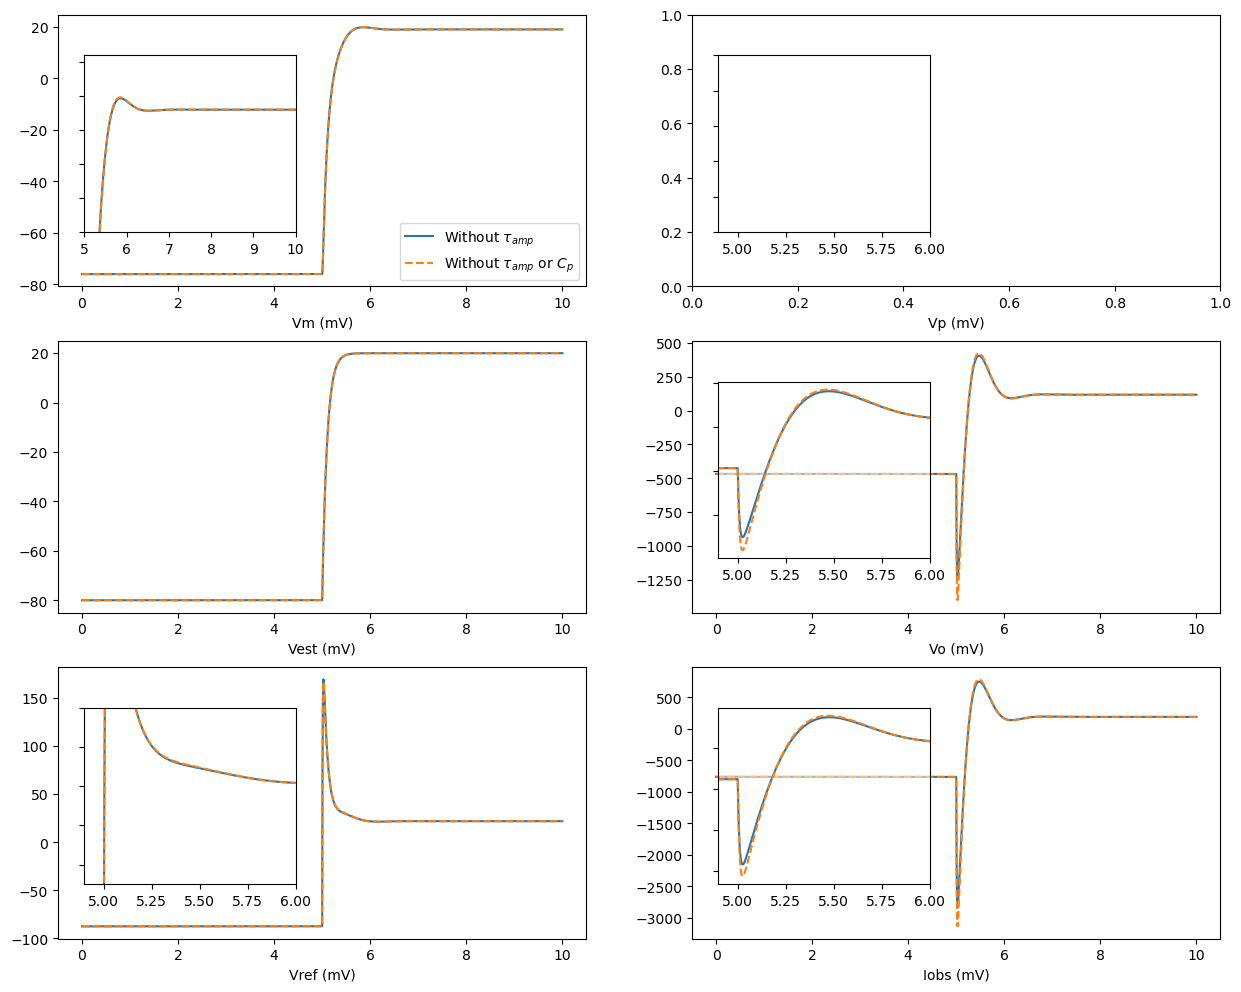

In [12]:
sAs.pre(t1)
sBs.pre(t1)
dAs = sAs.run(t0)
dBs = sBs.run(t0)
ax = plot(dAs, t1, t2, label=r'Without $\tau_{amp}$')
ax = plot(dBs, t1, t2, ls='--', axes=ax, label=r'Without $\tau_{amp}$ or $C_p$')
ax[0].legend(loc='lower right')
plt.show()

Similarly, we might chose to omit the term $C_f \dot{V}_\text{ref}$, although note that we still need to maintain $C_f$ in the model for its role in determining the time constants $R_fC_f$ and $R_sC_f$ of the first terms.

In [13]:
mCs = myokit.parse_model('''
[[model]]
desc: Simplified model without Cp and Cp_est, and omitting the "spike" from Cf
amp.Vm = -80
amp.Vo = -80
amp.Ve = -80
amp.Vr = -80

[engine]
time = 0 [ms] in [ms] bind time
pace = 0 bind pace

[amp]
alpha = 0.7
beta = 0.7
Rs = 15e-3 [GOhm] in [GOhm]
Rs_est = 14e-3 [GOhm] in [GOhm]
Cm = 25 [pF] in [pF]
Cm_est = 24 [pF] in [pF]
Rf = 0.5 [GOhm] in [GOhm]
Cf = 0.15 [pF] in [pF]
tau_sum = 10e-3 [ms] in [ms]
I = 10 [nS] * Vm
    in [pA]
Vc = engine.pace * 1 [mV]
    in [mV]
dot(Vm) = (Vr - Vm) / (Rs * Cm) - I / Cm
    in [mV]
dot(Vo) = ((Vr - Vm) / Rs - (Vo - Vr) / Rf - Cm_est * dot(Ve)) / Cf
    in [mV]
dot(Ve) = (Vc - Ve) / ((1 - beta) * Rs_est * Cm_est)
    in [mV]
dot(Vr) = (Vc + alpha * Rs_est * I_obs + beta * Rs_est * Cm_est * dot(Ve) - Vr) / tau_sum
    in [mV]
I_obs = (Vo - Vr) / Rf
    in [pA]
''')
mCs.check_units(myokit.UNIT_STRICT)

In [14]:
sCs = myokit.Simulation(mCs, p)
sCs.set_tolerance(tol, tol)
sCs.pre(t1)
dCs = sCs.run(t0)

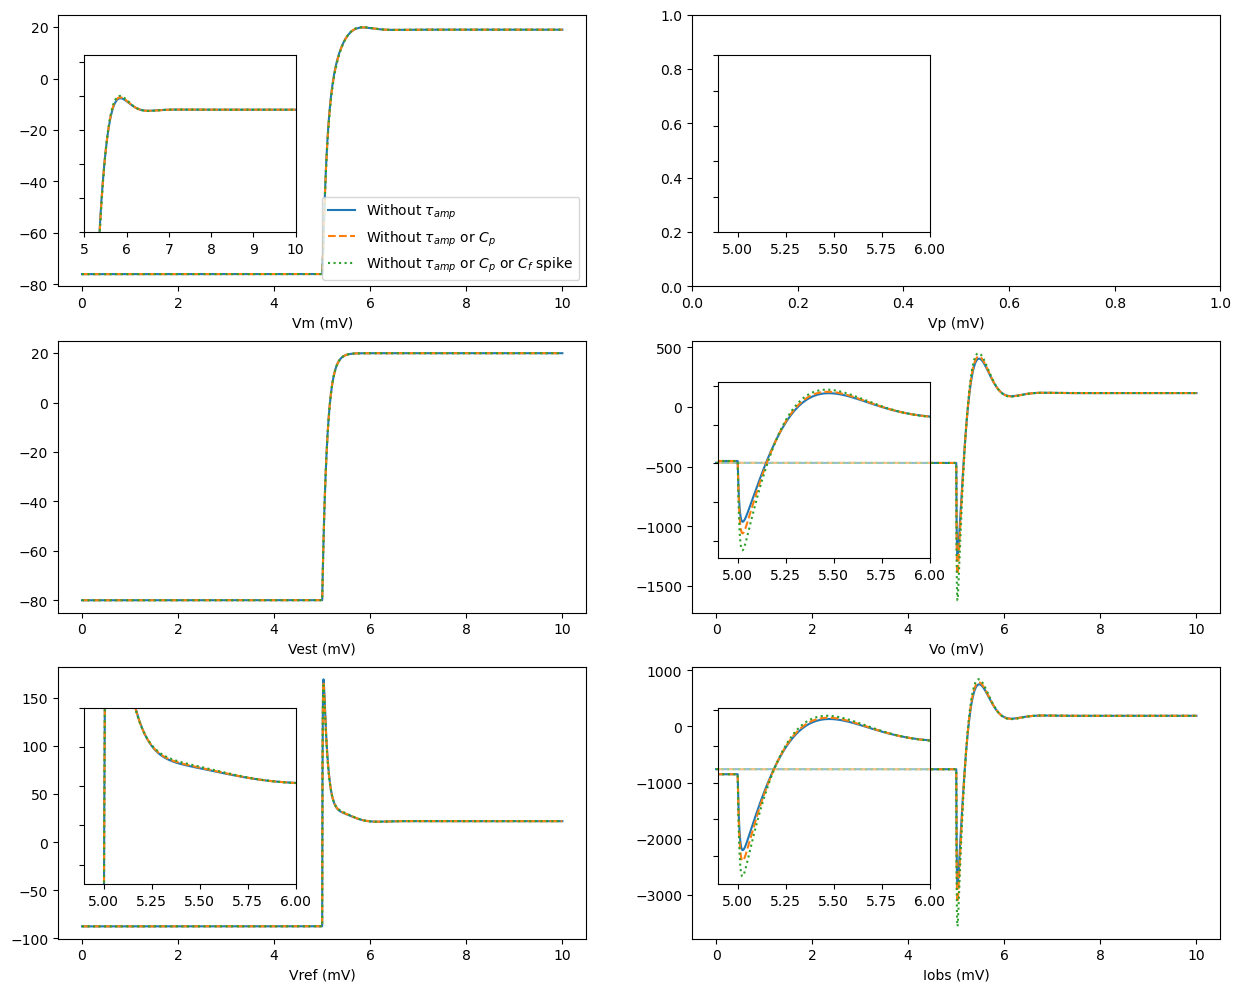

In [15]:
ax = plot(dAs, t1, t2, label=r'Without $\tau_{amp}$')
ax = plot(dBs, t1, t2, ls='--', axes=ax, label=r'Without $\tau_{amp}$ or $C_p$')
ax = plot(dCs, t1, t2, ls=':', axes=ax, label=r'Without $\tau_{amp}$ or $C_p$ or $C_f$ spike')
ax[0].legend(loc='lower right')
plt.show()

## Alternative formulation

We now have the model

\begin{align}
3.1. && C_m\dot{V}_m = \frac{V_\text{ref} - V_m}{R_s} - I
\end{align}

\begin{align}
3.2b. && C_f\dot{V}_o &= \frac{V_\text{ref} - V_m}{R_s} - \frac{V_o - V_\text{ref}}{R_f} + C_f \dot{V}_\text{ref} - C_m^* \dot{V}_\text{est}
\end{align}

\begin{align}
3.3. && \dot{V}_\text{est} &= \frac{V_c - V_\text{est}}{(1 - \beta)R_s^*C_m^*}   
\end{align}

\begin{align}
3.4. && \tau_\text{sum}\dot{V}_\text{ref} = V_c + \alpha R_s^* I_\text{obs} + \beta R_s^* C_m^* \dot{V}_\text{est} - V_\text{ref}
\end{align}

\begin{align}
3.5. && R_f I_\text{obs} &= V_o - V_\text{ref}
\end{align}

To write it in the style of Lei et al., we turn 3.5 into an ODE:

\begin{align}
R_f \dot{I}_\text{obs} &= \dot{V}_o - \dot{V}_\text{ref}
\end{align}

Multiply by $C_f$, fill in 3.2b, then 3.5, then 3.1 to find

\begin{align}
R_fC_f \dot{I}_\text{obs} 
    &= C_f\dot{V}_o - C_f\dot{V}_\text{ref} \\
    &= \frac{V_\text{ref} - V_m}{R_s} - \frac{V_o - V_\text{ref}}{R_f} + C_f\dot{V}_\text{ref} - C_m^* \dot{V}_\text{est} - C_f \dot{V}_\text{ref} \\
    &= \frac{V_\text{ref} - V_m}{R_s} - C_m^* \dot{V}_\text{est} - I_\text{obs} \\
\tau_f \dot{I}_\text{obs} &= I + C_m\dot{V}_m - C_m^* \dot{V}_\text{est} - I_\text{obs}
\end{align}

With this equation, the simplified model becomes:

\begin{align}
3.1. && C_m\dot{V}_m = \frac{V_\text{ref} - V_m}{R_s} - I
\end{align}

\begin{align}
3.3. && \dot{V}_\text{est} &= \frac{V_c - V_\text{est}}{(1 - \beta)R_s^*C_m^*}   
\end{align}

\begin{align}
3.4. && \tau_\text{sum}\dot{V}_\text{ref} = V_c + \alpha R_s^* I_\text{obs} + \beta R_s^* C_m^* \dot{V}_\text{est} - V_\text{ref}
\end{align}

\begin{align}
3.2c. && \tau_f \dot{I}_\text{obs} &= I + C_m\dot{V}_m - C_m^* \dot{V}_\text{est} - I_\text{obs}
\end{align}

Besides dropping from 5 to 4 equations, this formulation lumps $R_f$ and $C_f$ into a single parameter $\tau_f = R_fC_f$. This has two benefits:
1. If we want to infer $R_f$ and $C_f$ (e.g. to account for the limited accuracy of the electrical components), then this formulation shows that it would lead to identifiability problems, and we should fit only their product $\tau_f$ instead.
2. We can account for clever electronics tricks that reduce the _apparent_ $\tau_f$ by using a smaller value.

## Initial conditions

How do we pick initial conditions for the model?
Ideally, we'd like to start in a stable position (with all derivatives equal to zero).

Looking at the equations, we can see that $V_\text{est}$ will approach $V_c$, so we can start with
\begin{align}
V_\text{est}(t = 0) = V_c(t = 0)
\end{align}

But after this it gets trickier:
$I_\text{obs}$ will approach $I$, because in a stable position $\dot{V}_m$ and $\dot{V}_\text{est}$ will be zero.
However, $I$ is a function of $V(m)$, so that we get
\begin{align}
I_\text{obs}(t=0) = I(V_m(t=0))
\end{align}
$V_\text{ref}$ will approach $V_c + \alpha R_s^*I_\text{obs}$, so that
\begin{align}
V_\text{ref}(t=0) = V_c + \alpha R_s^* I(V_m(t=0))
\end{align}
Finally, $V_m$ will approach
\begin{align}
V_m(t=0) &= V_\text{ref}(t=0) - R_s I(V_m(t=0)) \\
         &= V_c - (R_s - \alpha R_s^*) I(V_m(t=0)) 
\end{align}

So all four initial states are functions of just $V_c$ and $I(V_m)$, and can be found by solving $V_m = V_c - (R_s - \alpha R_s^*) I(V_m)$.
Typical values are 
\begin{align}
V_c &= -80 \text{mV}\\
R_s = R_s^* &= 10 \text{MOhm} = 0.01 \text{GOhm} \\
\alpha = 0.7
\end{align}
for $V_m = -80 - 0.003 I(V_m)$.
The solutions of this $V = f(V)$ system can be found graphically, by looking for all crossings with the diagonal.

In general, the existence and uniqueness of the solution depends on $I(V_m)$, so that we can't say much more.
But for cell electrophysiology we know that

1. Most currents have very small steady-state currents. And many experiments we simulate will start at a holding potential chosen to _make_ the steady-state current small.
2. One of the few currents to worry about is IK1, either when we measure it directly or as part of a whole cell (where it will dominate the steady-state behaviour at negative potentials).
3. However, the multiplier 0.003 makes this less of a problem, as it makes any function $I(V)$ very flat which decreases the chance of their being more than one intersection with the diagonal.

Below we show an example based on the IK1 model from [Nygren et al. 1998](https://doi.org/10.1161/01.res.82.1.63).

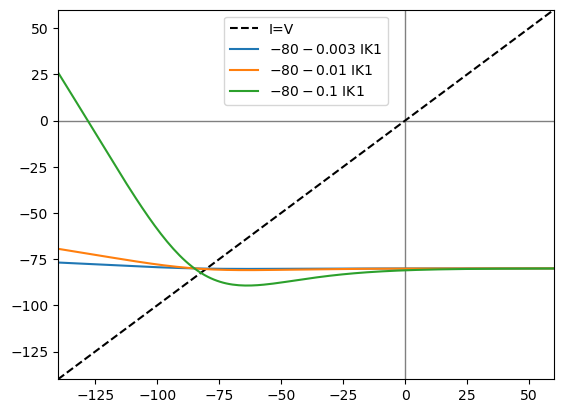

In [16]:
V = np.linspace(-140, 60, 160)
IK1 = 20 * (V + 85) / (1 + np.exp(0.06 * (V + 85)))

fig = plt.figure()
ax = fig.add_subplot()
ax.axhline(0, color='gray', lw=1)
ax.axvline(0, color='gray', lw=1)
ax.plot(V, V, 'k--', label='I=V')
ax.plot(V, -80 - 0.003*IK1, label='$-80 - 0.003$ IK1')
ax.plot(V, -80 - 0.01*IK1, label='$-80 - 0.01$ IK1')
ax.plot(V, -80 - 0.1*IK1, label='$-80 - 0.1$ IK1')
ax.set_xlim(-140, 60)
ax.set_ylim(-140, 60)
ax.legend()
plt.show()

Here, we've first plotted the case with 70% series resistance compensation and $R_s = 10$ MOhm (blue).
Next, the same but without series resistance compensation (orange).
And finally $R_s = 100$ MOhm without series resistance compensation (green).

For all three cases, there looks to be only a single solution.
This means we can work out $V_m(t=0)$ with an iterative scheme, or simply by starting at $V_m(t=0)=V_c$ and running a short simulation (typically a few milliseconds) to find the value it settles at.

## Model and parameters

To get the final model, we use the alternative formulation and add back in the remaining voltage offset $E_\text{off}^\dagger$ and leak to find:

\begin{align}
I_\text{leak} = \frac{V_m - E_\text{leak}}{R_\text{leak}}
\end{align}

\begin{align}
C_m\dot{V}_m = \frac{V_\text{ref} +E_\text{off}^\dagger - V_m}{R_s} - I - I_\text{leak}
\end{align}

\begin{align}
\dot{V}_\text{est} &= \frac{V_c - V_\text{est}}{(1 - \beta)R_s^*C_m^*}   
\end{align}

\begin{align}
\tau_\text{sum}\dot{V}_\text{ref} = V_c + \alpha R_s^* I_\text{obs} + \beta R_s^* C_m^* \dot{V}_\text{est} - V_\text{ref}
\end{align}

\begin{align}
\tau_f \dot{I}_\text{obs} &= I + I_\text{leak} + C_m\dot{V}_m - C_m^* \dot{V}_\text{est} - I_\text{obs}
\end{align}

With a user defined $I=I(V_m)$, an input $V_c$, and the following parameters:

| Parameter              | Meaning                     | Source       | Approximation   |
|:-----------------------|:----------------------------|:-------------|-----------------|
| $C_m$                  | Membrane capacitance        | Unknown      | $C_m^*$         |
| $C_m^*$                | Estimated $C_m$             | User setting |                 |
| $R_s$                  | Series resistance           | Unknown      | $R_s^*$         |
| $R_s^*$                | Estimated $R_s$             | User setting |                 |
| $\tau_f$               | Feedback time constant      | [Appendix C3](appendix-C3-parameter-values) | |
| $\tau_\text{sum}$      | $R_s$ compensation lag      | User setting |                 |
| $\alpha$               | $R_s$ compensation fraction | User setting |                 |
| $\beta$                | $R_s$ prediction fraction   | User setting |                 |
| $E_\text{off}^\dagger$ | Remaining voltage offset    | Unknown      | 0               |
| $E_\text{leak}$        | Leak offset                 | Unknown      | 0               |
| $R_\text{leak}$        | Leak resistance             | Unknown      | $R_\text{seal}$ |


Estimates for $C_m$ and $R_s$ are usually made before running the experiment. But we could also choose to infer these values, or use the correction estimates $C_m^*$ and $R_s^*$.

Similarly, a pre-experiment estimate for $R_\text{seal}$ (or $R_\text{memb}$) is often available, and could be used for $R_\text{leak}$.
Alternatively, a special leak-estimation step could be included in each protocol (especially if $E_\text{leak}$ appears to be non-zero).

On many amplifiers $\alpha$, $\beta$, $R_s^*$ and $C_m^*$ will be read off from a dial, so perhaps should include an error to infer.
On some amplifiers $\alpha = \beta$, removing one parameter.



### Capacitance-normalised model

If we want to use capacitance-normalised currents $\tilde{I}_x = I_x / C'_m$, we get the following equations:

\begin{align}
\tilde{I}_\text{leak} = \frac{V_m - E_\text{leak}}{R_\text{leak} C'_m} \end{align}

\begin{align}
\dot{V}_m = \frac{V_\text{ref} +E_\text{off}^\dagger - V_m}{R_s C_m} - \frac{C_m'}{C_m} (\tilde{I} + \tilde{I}_\text{leak})
\end{align}

\begin{align}
\dot{V}_\text{est} &= \frac{V_c - V_\text{est}}{(1 - \beta)R_s^*C_m^*}   
\end{align}

\begin{align}
\tau_\text{sum}\dot{V}_\text{ref} = V_c + \alpha R_s^* C'_m \tilde{I}_\text{obs} + \beta R_s^* C_m^* \dot{V}_\text{est} - V_\text{ref}
\end{align}

\begin{align}
\tau_f \dot{\tilde{I}}_\text{obs} &= \tilde{I} + \tilde{I}_\text{leak} + \frac{C_m}{C'_m}\dot{V}_m - \frac{C_m^*}{C'_m} \dot{V}_\text{est} - \tilde{I}_\text{obs}
\end{align}

Where we have differentiated between
1. $C_m$: The true, unknown, capacitance
2. $C_m^*$: The estimate of $C_m$ used in capacitance correction
3. $C'_m$: The estimate of $C_m$ used in normalisation.


## Conclusion

We have shown that

1. Omitting the op-amp dynamics removes any differences between the model formulation based on Sigworth 1995 and on Lei 2020, and leads to visually indistinguishable results.
2. Omitting the effects of $C_p$ and $C_p^*$, or even the capacitative spike due to $C_f$, leads to transient differences at the start of any step change, but may be beneficial for parameter estimation purposes.
3. The final model can be reformulated to lump $R_f$ and $C_f$ into a single parameter $\tau_f$, which can be beneficial.
4. For typical electrophysiology models, we can find a clamped steady-state by just running a short simulation.
5. Although the final model has 11 parameters, we usually only need to infer a few.